<a href="https://colab.research.google.com/github/chegeveronica/whatsappchatanalysis/blob/main/WhatsappChatAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [59]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
#function to get the date and time
def startsWithDateAndTimeAndroid(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [61]:
#format of date,time - author: message
#get the author
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [62]:
#get data from an android

def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [7]:
#get data for ios
# def getDataPointios(line):
#     splitLine = line.split('] ')
#     dateTime = splitLine[0]
#     if ',' in dateTime:
#         date, time = dateTime.split(',')
#     else:
#         date, time = dateTime.split(' ')
#     message = ' '.join(splitLine[1:])
#     if FindAuthor(message):
#         splitMessage = message.split(':')
#         author = splitMessage[0]
#         message = ' '.join(splitMessage[1:])
#     else:
#         author = None
#     if time[5]==":":
#         time = time[:5]+time[-3:]
#     else:
#         if 'AM' in time or 'PM' in time:
#             time = time[:6]+time[-3:]
#         else:
#             time = time[:6]
#     return date, time, author, message

In [64]:
#get the emojis

def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.distinct_emoji_list(text) for char in word):
            emoji_list.append(word)

    return emoji_list

In [67]:
#upload the data and get analysis

parsedData = [] # List for the data
conversationPath = '/content/chat.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    # if '[' in first:
    #   device='ios'
    # else:
    device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None 
    while True:
        line = fp.readline() 
        if not line: 
            break
        # if device=="ios":
        #   line = line.strip()
        #   if startsWithDateAndTimeios(line):
        #     if len(messageBuffer) > 0:
        #       parsedData.append([date, time, author, ' '.join(messageBuffer)])
        #     messageBuffer.clear()
        #     date, time, author, message = getDataPointios(line)
        #     messageBuffer.append(message)
        #   else:
        #     line= (line.encode('ascii', 'ignore')).decode("utf-8")
        #     if startsWithDateAndTimeios(line):
        #       if len(messageBuffer) > 0:
        #         parsedData.append([date, time, author, ' '.join(messageBuffer)])
        #       messageBuffer.clear()
        #       date, time, author, message = getDataPointios(line)
        #       messageBuffer.append(message)
        #     else:
        #       messageBuffer.append(line)
        # else:
        line = line.strip()
        if startsWithDateAndTimeAndroid(line):
          if len(messageBuffer) > 0:
            parsedData.append([date, time, author, ' '.join(messageBuffer)])
          messageBuffer.clear()
          date, time, author, message = getDataPointAndroid(line)
          messageBuffer.append(message)
        else:
          messageBuffer.append(line)

26/01/2022, 10:11 - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.



In [68]:
# if device =='android':
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df["Date"] = pd.to_datetime(df["Date"])
df = df.dropna()
df["emoji"] = df["Message"].apply(split_count)
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
# else:
#         df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
#         df = df.dropna()
#         df["Date"] = df["Date"].apply(dateconv)
#         df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
#         df["emoji"] = df["Message"].apply(split_count)
#         URLPATTERN = r'(https?://\S+)'
#         df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [90]:
#df.head(10)

In [91]:
#df.info                                              #info about the group chat

In [92]:
#df.Author.unique()                                              #unique names of authors

In [93]:
df= df.dropna() #droppping null values
#df.info

In [74]:
total_messages = df.shape[0]
print(total_messages)

6155


In [75]:
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print(media_messages)

0


In [76]:
emojis = sum(df['emoji'].str.len())
print(emojis)

4063


In [77]:
URLPATTERN = r'(https?://\S+)' #regex pattern matching with start with https
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len() #return url which matches with pattern and count it through lambda function
links = np.sum(df.urlcount) #sumup all the links
print(links)

3


In [78]:
#separating text and media messages

link_messages = df[df['urlcount'] > 0]
media_messagesdf = df[(df['Message'] == '<Media omitted>') | (df['Message'] == '<image omitted>')|(df['Message'] == '<video omitted>')|(df['Message']== '<sticker omitted>')]
deleted_messagesdf = df[(df['Message'] == 'This message was deleted') | df['Message'] == 'You deleted this message']
messagesdf = df.drop(media_messagesdf.index)
messagesdf = messagesdf.drop(deleted_messagesdf.index)
messagesdf = messagesdf.drop(link_messages.index)
 

In [79]:
messagesdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6152 entries, 0 to 6297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      6152 non-null   datetime64[ns]
 1   Time      6152 non-null   object        
 2   Author    6152 non-null   object        
 3   Message   6152 non-null   object        
 4   emoji     6152 non-null   object        
 5   urlcount  6152 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 336.4+ KB


In [80]:
#calculate words and letters
messagesdf['letter_count'] = messagesdf['Message'].apply(lambda s : len(s))
messagesdf['word_count'] = messagesdf['Message'].apply(lambda s : len(s.split(' ')))
messagesdf['Messagecount']=1

In [94]:
#messagesdf.head(10)

In [82]:
messagesdf['emojicount'] = df['emoji'].str.len()
print(messagesdf['emojicount'])

0       0
1       3
2       1
3       1
4       0
       ..
6293    1
6294    1
6295    0
6296    0
6297    0
Name: emojicount, Length: 6152, dtype: int64


In [83]:
# authors analysis

chat = messagesdf.Author.unique()
for i in range(len(chat)):
  #messages of a particular user
  user_df = messagesdf[messagesdf['Author'] == chat[i]]
  print(f'stats of {chat[i]} -')
  #no. of messages sent, since row == no.of messages
  print('messages sent', user_df.shape[0])
  #word count
  words_per_message = (np.sum(user_df['word_count']))/user_df.shape[0]
  print('words_per_message:', words_per_message) 
  #media messages
  media = media_messagesdf[media_messagesdf['Author'] == chat[i]].shape[0]
  print('media messages sent:', media)
  #total emojis
  emojis = sum(user_df['emoji'].str.len())
  print('Emojis sent:',emojis)
  #total links
  links = sum(link_messages[link_messages['Author'] == chat[i]]['urlcount'])
  print('Links shared:', links)
  print()

stats of Andrew -
messages sent 3174
words_per_message: 7.773471959672338
media messages sent: 0
Emojis sent: 1972
Links shared: 3

stats of vero -
messages sent 2978
words_per_message: 9.97951645399597
media messages sent: 0
Emojis sent: 2086
Links shared: 0



In [84]:
#Emojis analysis
#unique emojis

emojis_list = list(set([a for b in messagesdf.emoji for a in b]))
total_emojis = len(emojis_list)
print(total_emojis)

68


In [103]:
#most used emojis
emojis_list = list([a for b in messagesdf.emoji for a in b])
emoji_dict = dict(Counter(emojis_list))
emoji_dict = sorted(emoji_dict.items(), key = lambda x: x[1], reverse=True)
#print(emoji_dict) 

In [95]:
emoji_df = pd.DataFrame(emoji_dict,columns=['emoji','count'])
print(emoji_df.head(3))

  emoji  count
0     😂   1434
1     😹    930
2     😅    365


In [113]:
#plot
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
#fig.update_traces(textposition='inside', textinfo='percent+label')
#fig.show()

Text(0, 0.5, 'Time')

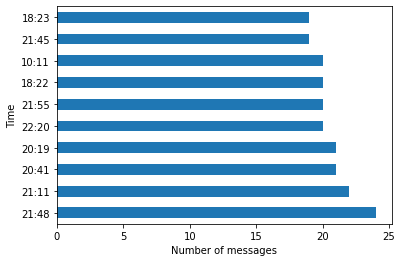

In [111]:
messagesdf['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')